In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

## Data Loading and Initial Inspection

In [2]:
# Load the dataset
file_path = '../data/benin-malanville.csv'
df = pd.read_csv(file_path)
# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (525600, 19)


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


## Summary Statistics & Missing-Value Report

In [3]:
# Summary statistics for numeric columns
df.describe()

,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,240.559452,167.187516,115.358961,236.589496,228.883576,28.179683,54.487969,2.121113,2.809195,0.473390,153.435172,8.582407,994.197199,0.000923,0.001905,35.246026,32.471736,NaN
std,331.131327,261.710501,158.691074,326.894859,316.536515,5.924297,28.073069,1.603466,2.029120,0.273395,102.332842,6.385864,2.474993,0.030363,0.037115,14.807258,12.348743,NaN
min,-12.900000,-7.800000,-12.600000,0.000000,0.000000,11.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,985.000000,0.000000,0.000000,9.000000,8.100000,NaN
25%,-2.000000,-0.500000,-2.100000,0.000000,0.000000,24.200000,28.800000,1.000000,1.300000,0.400000,59.000000,3.700000,993.000000,0.000000,0.000000,24.200000,23.600000,NaN
50%,1.800000,-0.100000,1.600000,4.500000,4.300000,28.000000,55.100000,1.900000,2.600000,0.500000,181.000000,8.600000,994.000000,0.000000,0.000000,30.000000,28.900000,NaN
75%,483.400000,314.200000,216.300000,463.700000,447.900000,32.300000,80.100000,3.100000,4.100000,0.600000,235.100000,12.300000,996.000000,0.000000,0.000000,46.900000,41.500000,NaN
max,1413.000000,952.300000,759.200000,1342.300000,1342.300000,43.800000,100.000000,19.500000,26.600000,4.200000,360.000000,99.400000,1003.000000,1.000000,2.500000,81.000000,72.500000,NaN


In [4]:
# Replace negative values with zero for irradiance measurements
irradiance_cols = ['GHI', 'DNI', 'DHI']
for col in irradiance_cols:
    df[col] = df[col].clip(lower=0)

In [5]:
# Check for missing values
na_counts = df.isna().sum()
na_percent = df.isna().mean() * 100
# Create a DataFrame to display both counts and percentages
na_info = pd.DataFrame({
    'Missing Values': na_counts,
    'Percentage': na_percent
})

print("Columns with >5% missing values:")
na_info[na_info['Percentage'] > 5].sort_values('Percentage', ascending=False)

Columns with >5% missing values:


,Missing Values,Percentage
Comments,525600,100.0


In [6]:
# Define key columns for outlier detection
key_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Create a copy of the dataframe for cleaning
df_clean = df.copy()


In [7]:
# Function to handle outliers using Z-score
def detect_and_clean_outliers(df, column):
    # Calculate z-scores
    z_scores = np.abs(stats.zscore(df[column].dropna()))
    
    # Identify outliers (|Z| > 3)
    outliers = z_scores > 3
    
    # Count outliers
    outlier_count = np.sum(outliers)
    print(f"{column}: {outlier_count} outliers detected")
    
    # Replace outliers with median in the clean dataframe
    median_val = df[column].median()
    outlier_indices = df[column].dropna().index[outliers]
    df_clean.loc[outlier_indices, column] = median_val
    
    return outlier_count

In [8]:
# Detect and clean outliers in key columns
total_outliers = 0
for col in key_cols:
    if col in df.columns:
        total_outliers += detect_and_clean_outliers(df, col)

print(f"Total outliers detected and cleaned: {total_outliers}")

GHI: 90 outliers detected
DNI: 2 outliers detected
DHI: 3889 outliers detected
ModA: 27 outliers detected
ModB: 63 outliers detected
WS: 3109 outliers detected
WSgust: 3500 outliers detected
Total outliers detected and cleaned: 10680


In [9]:
# Impute missing values in key columns with median
for col in key_cols:
    if col in df_clean.columns and df_clean[col].isna().sum() > 0:
        print(f"Imputing {df_clean[col].isna().sum()} missing values in {col}")
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# Drop the Comments column as it's 100% missing
if 'Comments' in df_clean.columns:
    df_clean = df_clean.drop('Comments', axis=1)



In [10]:
# Export cleaned data
clean_path = '../data/benin_clean.csv'
df_clean.to_csv(clean_path, index=False)
print(f"Cleaned data exported to {clean_path}")

Cleaned data exported to ../data/benin_clean.csv


In [11]:
# Ensure Timestamp is in datetime format
if not pd.api.types.is_datetime64_any_dtype(df_clean['Timestamp']):
    df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])

# Extract time components for analysis
df_clean['Hour'] = df_clean['Timestamp'].dt.hour
df_clean['Month'] = df_clean['Timestamp'].dt.month
df_clean['Day'] = df_clean['Timestamp'].dt.day
df_clean['Date'] = df_clean['Timestamp'].dt.date

In [12]:
# 1. Create time series plots for solar components and temperature
plt.figure(figsize=(16, 12))

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

In [13]:
# Select a shorter period (e.g., one week) for clearer visualization
start_date = df_clean['Timestamp'].min()
end_date = start_date + pd.Timedelta(days=7)
week_data = df_clean[(df_clean['Timestamp'] >= start_date) & (df_clean['Timestamp'] <= end_date)]

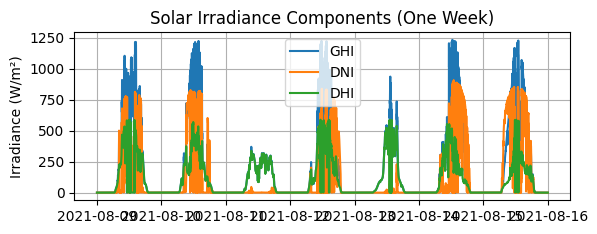

In [14]:
# Plot GHI, DNI, DHI
plt.subplot(2, 1, 1)
plt.plot(week_data['Timestamp'], week_data['GHI'], label='GHI')
plt.plot(week_data['Timestamp'], week_data['DNI'], label='DNI')
plt.plot(week_data['Timestamp'], week_data['DHI'], label='DHI')
plt.title('Solar Irradiance Components (One Week)')
plt.ylabel('Irradiance (W/m²)')
plt.legend()
plt.grid(True)

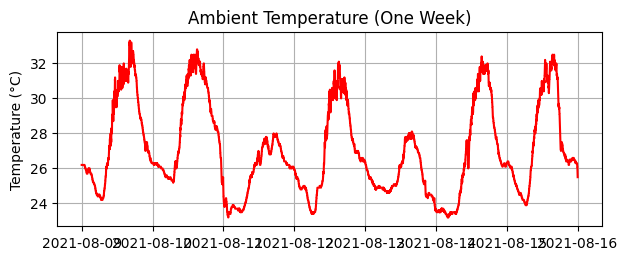

In [15]:
# Plot Temperature
plt.subplot(2, 1, 2)
plt.plot(week_data['Timestamp'], week_data['Tamb'], color='red')
plt.title('Ambient Temperature (One Week)')
plt.ylabel('Temperature (°C)')
plt.grid(True)

plt.tight_layout()
plt.savefig('../data/benin_time_series_week.png')
plt.show()

In [16]:
# 2. Monthly patterns - average daily irradiance by month
plt.figure(figsize=(14, 8))
monthly_avg = df_clean.groupby('Month')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

<Figure size 1400x800 with 0 Axes>

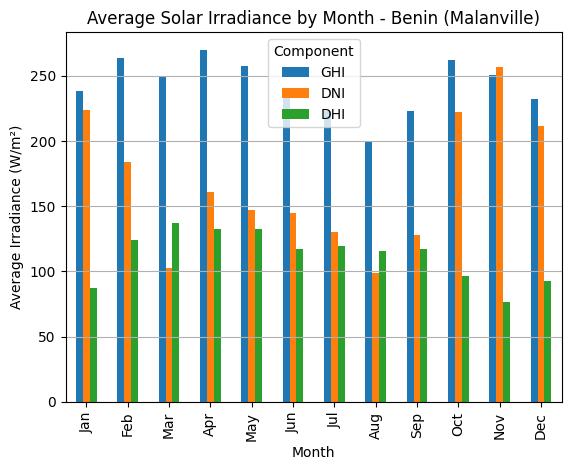

In [17]:
# Plot monthly averages as bar chart
monthly_avg[['GHI', 'DNI', 'DHI']].plot(kind='bar')
plt.title('Average Solar Irradiance by Month - Benin (Malanville)')
plt.xlabel('Month')
plt.ylabel('Average Irradiance (W/m²)')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y')
plt.legend(title='Component')
plt.savefig('../data/benin_monthly_irradiance.png')
plt.show()

In [18]:
# 3. Daily patterns - hourly averages
plt.figure(figsize=(14, 8))
hourly_avg = df_clean.groupby('Hour')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()

<Figure size 1400x800 with 0 Axes>

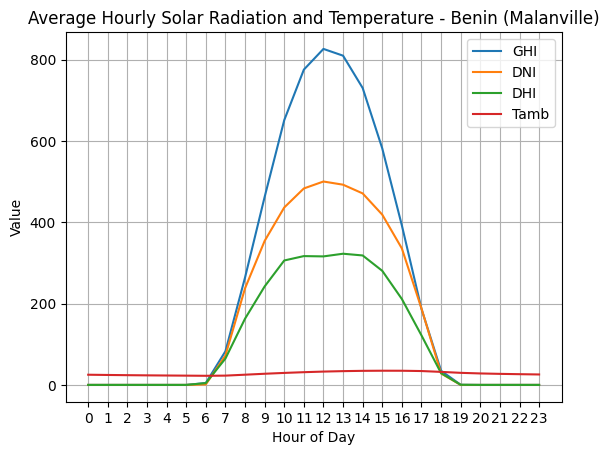

In [19]:
# Plot hourly patterns
hourly_avg.plot()
plt.title('Average Hourly Solar Radiation and Temperature - Benin (Malanville)')
plt.xlabel('Hour of Day')
plt.ylabel('Value')
plt.xticks(range(24))
plt.grid(True)
plt.legend()
plt.savefig('../data/benin_hourly_patterns.png')
plt.show()

In [20]:
# 4. Find and visualize anomalies
# Calculate daily max values
daily_max = df_clean.groupby('Date').agg({
    'GHI': 'max',
    'Tamb': 'max'
}).reset_index()

# Find days with anomalous peaks (top 1%)
ghi_threshold = np.percentile(daily_max['GHI'], 99)
temp_threshold = np.percentile(daily_max['Tamb'], 99)

anomalous_days = daily_max[(daily_max['GHI'] > ghi_threshold) | 
                           (daily_max['Tamb'] > temp_threshold)]

print(f"Detected {len(anomalous_days)} days with anomalous peaks")
print("Top 5 days with highest GHI or temperature:")
print(anomalous_days.sort_values(by=['GHI', 'Tamb'], ascending=False).head())

Detected 7 days with anomalous peaks
Top 5 days with highest GHI or temperature:
           Date     GHI  Tamb
37   2021-09-15  1232.0  34.1
347  2022-07-22  1232.0  32.9
5    2021-08-14  1232.0  32.4
258  2022-04-24  1066.0  43.8
241  2022-04-07  1000.0  43.6


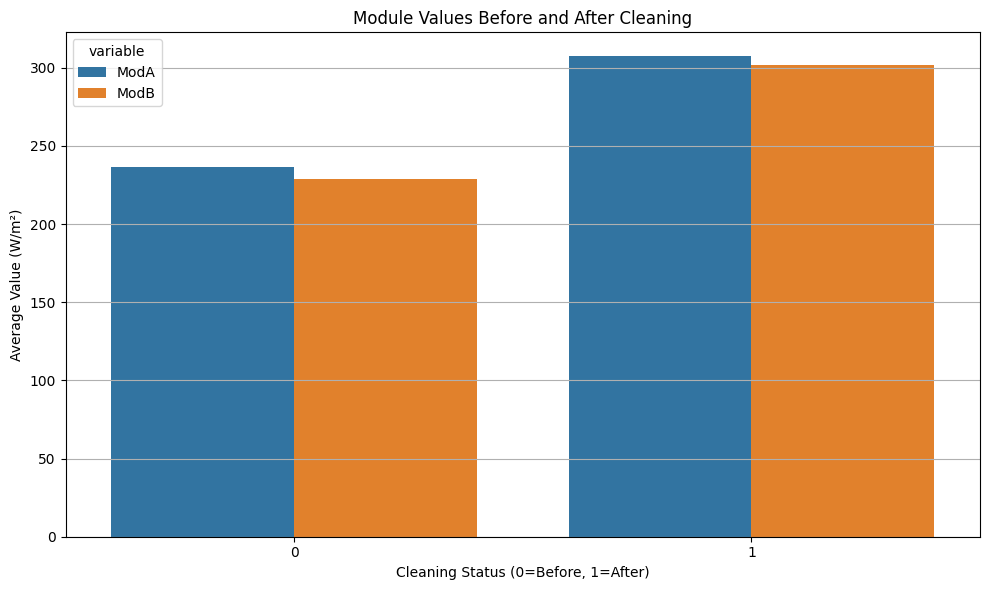

Percentage change after cleaning:
ModA: 29.93%
ModB: 32.06%


In [21]:
# 1. CLEANING IMPACT ANALYSIS
# Check if Cleaning flag exists in dataset
if 'Cleaning' in df_clean.columns:
    plt.figure(figsize=(10, 6))
    
    # Group data by cleaning flag
    cleaning_impact = df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean().reset_index()
    
    # Convert to format needed for seaborn
    impact_data = pd.melt(cleaning_impact, id_vars=['Cleaning'], 
                          value_vars=['ModA', 'ModB'])
    
    # Create bar plot showing pre/post cleaning values
    sns.barplot(x='Cleaning', y='value', hue='variable', data=impact_data)
    plt.title('Module Values Before and After Cleaning')
    plt.xlabel('Cleaning Status (0=Before, 1=After)')
    plt.ylabel('Average Value (W/m²)')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig('../data/benin_cleaning_impact.png')
    plt.show()
    
    print("Percentage change after cleaning:")
    if len(cleaning_impact) > 1:  # Ensure both values exist
        change_moda = ((cleaning_impact.loc[1, 'ModA'] - cleaning_impact.loc[0, 'ModA']) / 
                       cleaning_impact.loc[0, 'ModA'] * 100)
        change_modb = ((cleaning_impact.loc[1, 'ModB'] - cleaning_impact.loc[0, 'ModB']) / 
                       cleaning_impact.loc[0, 'ModB'] * 100)
        print(f"ModA: {change_moda:.2f}%")
        print(f"ModB: {change_modb:.2f}%")

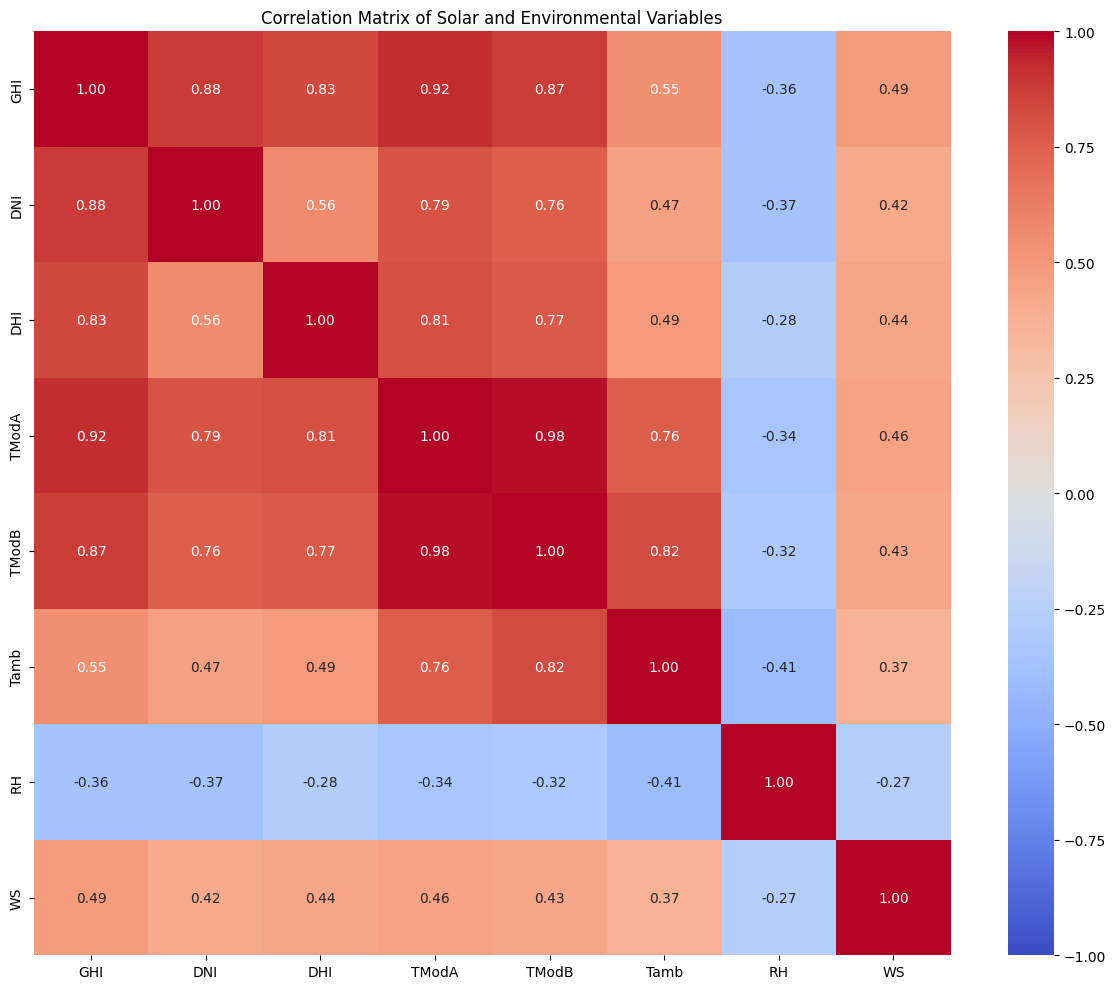

In [22]:
# 2. CORRELATION & RELATIONSHIP ANALYSIS
# Define columns for correlation analysis
corr_cols = ['GHI', 'DNI', 'DHI']
if 'TModA' in df_clean.columns: corr_cols.append('TModA')
if 'TModB' in df_clean.columns: corr_cols.append('TModB')
if 'Tamb' in df_clean.columns: corr_cols.append('Tamb')
if 'RH' in df_clean.columns: corr_cols.append('RH')
if 'WS' in df_clean.columns: corr_cols.append('WS')

# Create correlation matrix
correlation = df_clean[corr_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix of Solar and Environmental Variables')
plt.tight_layout()
plt.savefig('../data/benin_correlation_heatmap.png')
plt.show()

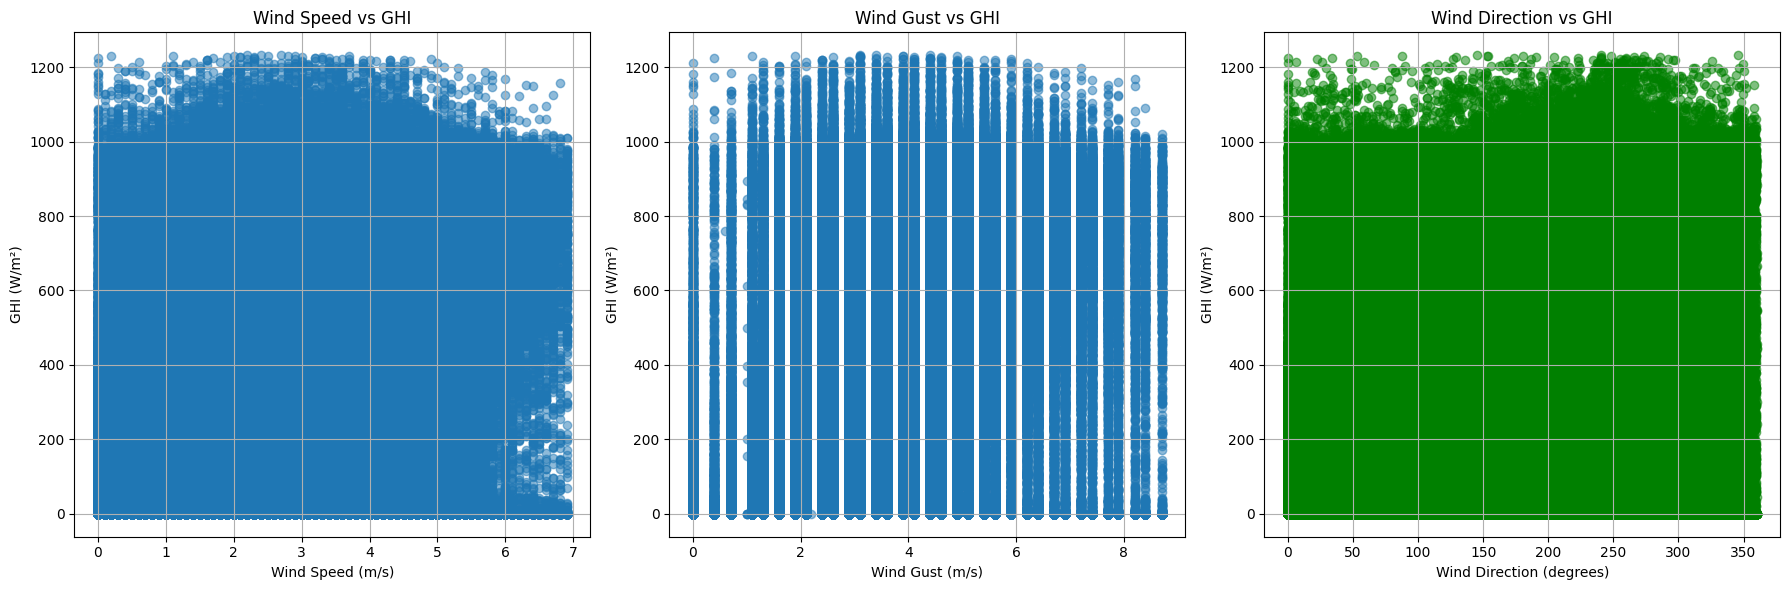

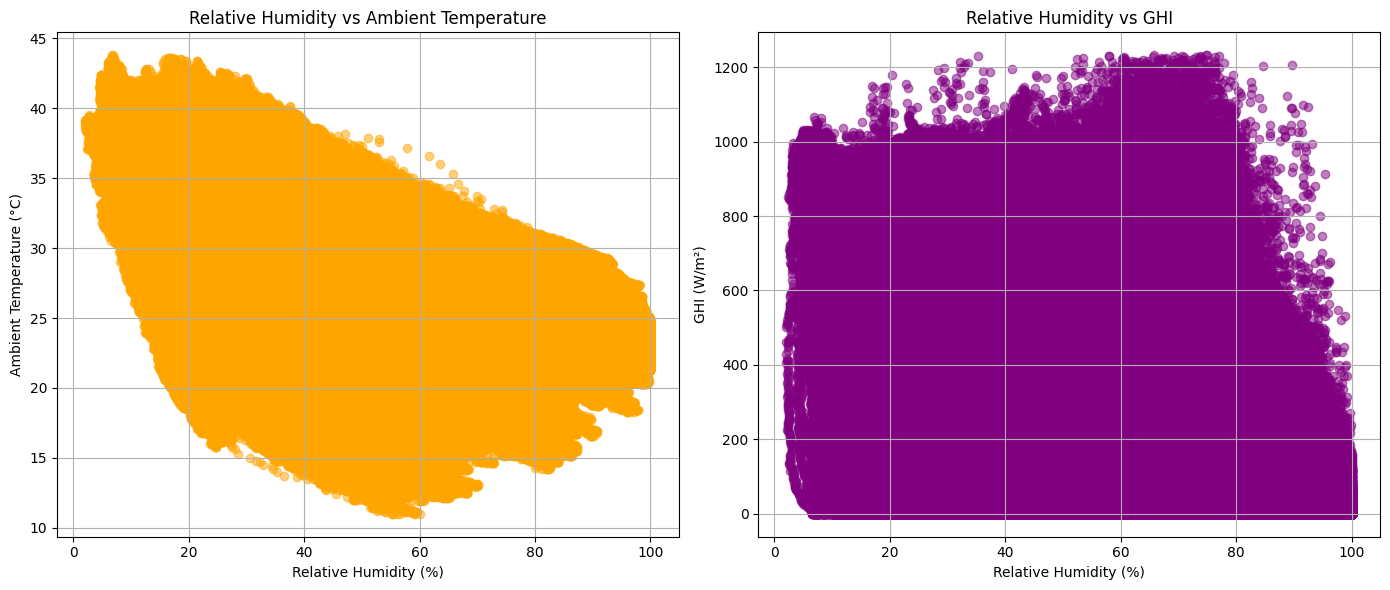

In [23]:
# Scatter plots for wind vs GHI
plt.figure(figsize=(18, 6))

# WS vs GHI
if all(col in df_clean.columns for col in ['WS', 'GHI']):
    plt.subplot(1, 3, 1)
    plt.scatter(df_clean['WS'], df_clean['GHI'], alpha=0.5)
    plt.title('Wind Speed vs GHI')
    plt.xlabel('Wind Speed (m/s)')
    plt.ylabel('GHI (W/m²)')
    plt.grid(True)
    
# WSgust vs GHI
if all(col in df_clean.columns for col in ['WSgust', 'GHI']):
    plt.subplot(1, 3, 2)
    plt.scatter(df_clean['WSgust'], df_clean['GHI'], alpha=0.5)
    plt.title('Wind Gust vs GHI')
    plt.xlabel('Wind Gust (m/s)')
    plt.ylabel('GHI (W/m²)')
    plt.grid(True)

# WD vs GHI
if all(col in df_clean.columns for col in ['WD', 'GHI']):
    plt.subplot(1, 3, 3)
    plt.scatter(df_clean['WD'], df_clean['GHI'], alpha=0.5, c='green')
    plt.title('Wind Direction vs GHI')
    plt.xlabel('Wind Direction (degrees)')
    plt.ylabel('GHI (W/m²)')
    plt.grid(True)

plt.tight_layout()
plt.savefig('../data/benin_wind_ghi_relationship.png')
plt.show()

# RH relationships
if 'RH' in df_clean.columns:
    plt.figure(figsize=(14, 6))
    
    # RH vs Tamb
    if 'Tamb' in df_clean.columns:
        plt.subplot(1, 2, 1)
        plt.scatter(df_clean['RH'], df_clean['Tamb'], alpha=0.5, c='orange')
        plt.title('Relative Humidity vs Ambient Temperature')
        plt.xlabel('Relative Humidity (%)')
        plt.ylabel('Ambient Temperature (°C)')
        plt.grid(True)
    
    # RH vs GHI
    if 'GHI' in df_clean.columns:
        plt.subplot(1, 2, 2)
        plt.scatter(df_clean['RH'], df_clean['GHI'], alpha=0.5, c='purple')
        plt.title('Relative Humidity vs GHI')
        plt.xlabel('Relative Humidity (%)')
        plt.ylabel('GHI (W/m²)')
        plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('../data/benin_humidity_relationships.png')
    plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_13908\4281796164.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_data = df_clean.groupby('WD_bin')['WS'].mean().reset_index()


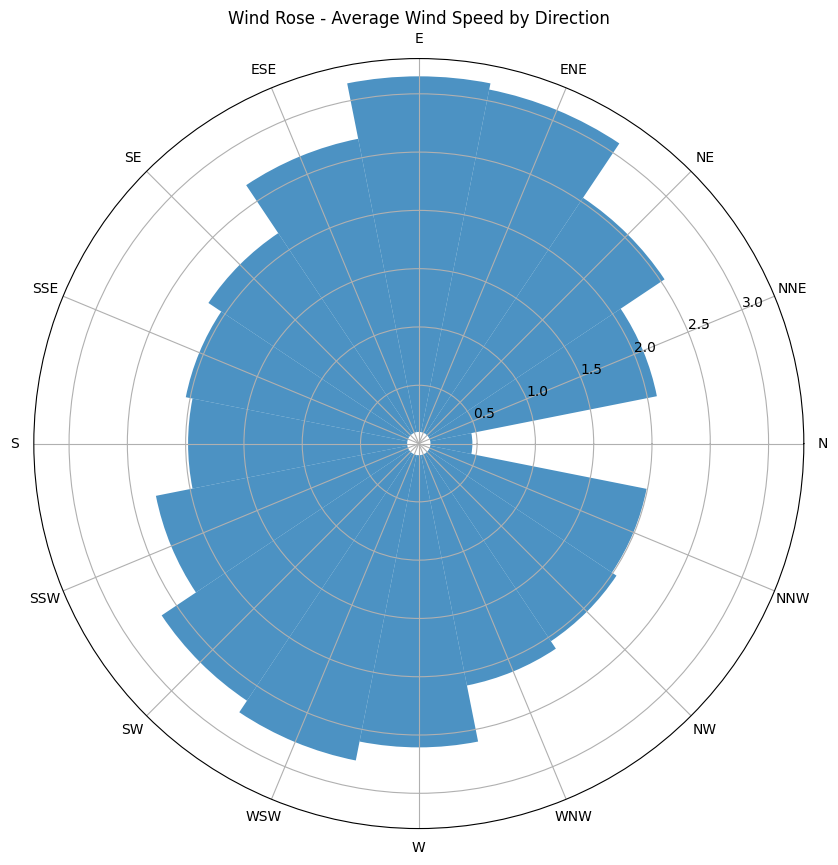

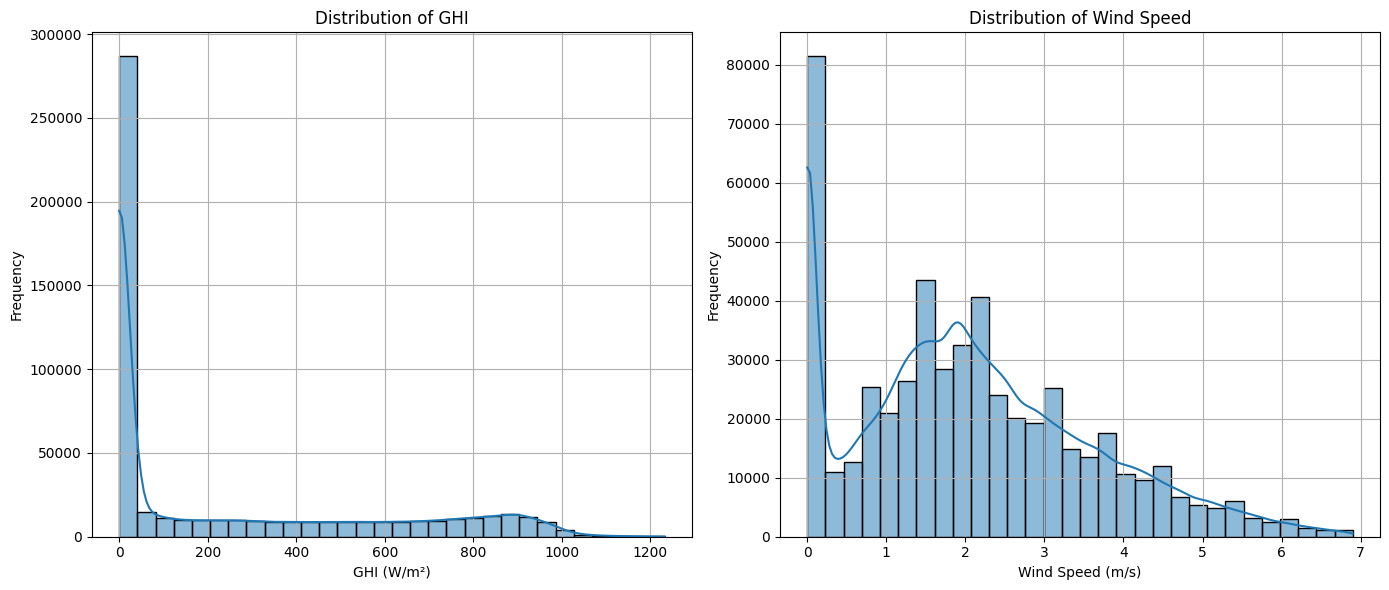

In [24]:
# 3. WIND & DISTRIBUTION ANALYSIS
# Wind rose plot
if all(col in df_clean.columns for col in ['WS', 'WD']):
    plt.figure(figsize=(10, 10))
    
    # Create 16 wind direction bins (N, NNE, NE, etc.)
    bins = np.linspace(0, 360, 17)
    labels = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 
              'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
    
    # Assign direction categories
    df_clean['WD_bin'] = pd.cut(df_clean['WD'], bins=bins, labels=labels, include_lowest=True)
    
    # Calculate average wind speed for each direction
    wind_data = df_clean.groupby('WD_bin')['WS'].mean().reset_index()
    
    # Create wind rose (polar bar chart)
    ax = plt.subplot(111, polar=True)
    theta = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    ax.bar(theta, wind_data['WS'], width=2*np.pi/16, bottom=0.1, alpha=0.8)
    
    # Set direction labels
    ax.set_xticks(theta)
    ax.set_xticklabels(labels)
    plt.title('Wind Rose - Average Wind Speed by Direction')
    plt.savefig('../data/benin_wind_rose.png')
    plt.show()

# Histograms for GHI and WS
plt.figure(figsize=(14, 6))

# GHI distribution
if 'GHI' in df_clean.columns:
    plt.subplot(1, 2, 1)
    sns.histplot(df_clean['GHI'], kde=True, bins=30)
    plt.title('Distribution of GHI')
    plt.xlabel('GHI (W/m²)')
    plt.ylabel('Frequency')
    plt.grid(True)

# Wind Speed distribution
if 'WS' in df_clean.columns:
    plt.subplot(1, 2, 2)
    sns.histplot(df_clean['WS'], kde=True, bins=30)
    plt.title('Distribution of Wind Speed')
    plt.xlabel('Wind Speed (m/s)')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.savefig('../data/benin_distributions.png')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_13908\1802453248.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_by_rh = df_clean.groupby('RH_bin')['Tamb'].mean().reset_index()


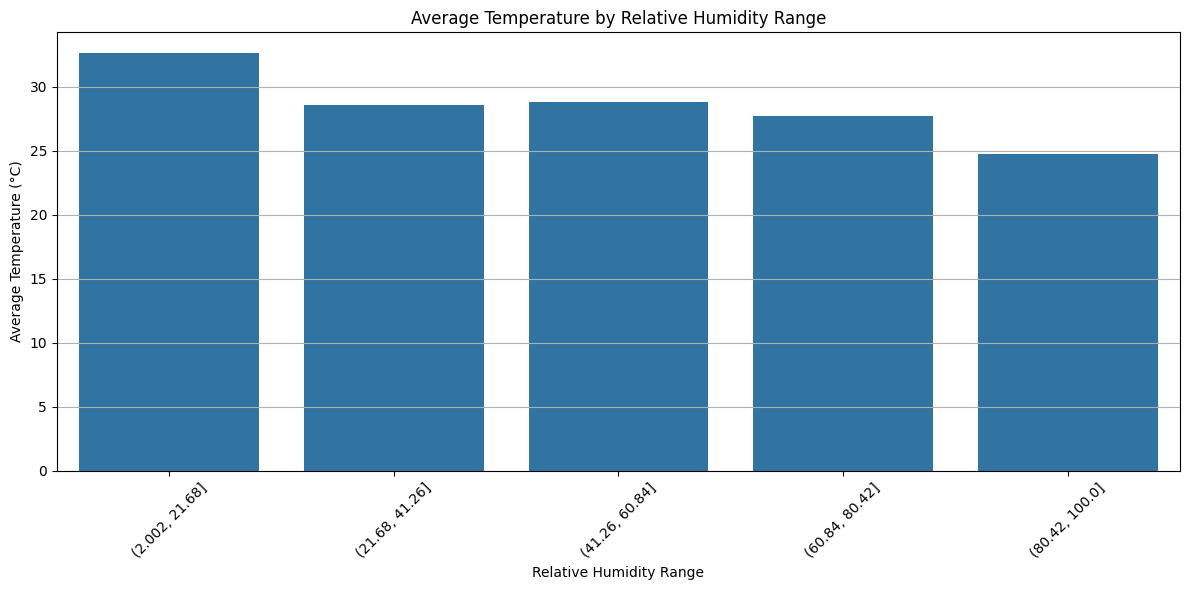

C:\Users\HP\AppData\Local\Temp\ipykernel_13908\1802453248.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ghi_by_rh = df_clean.groupby('RH_bin')['GHI'].mean().reset_index()


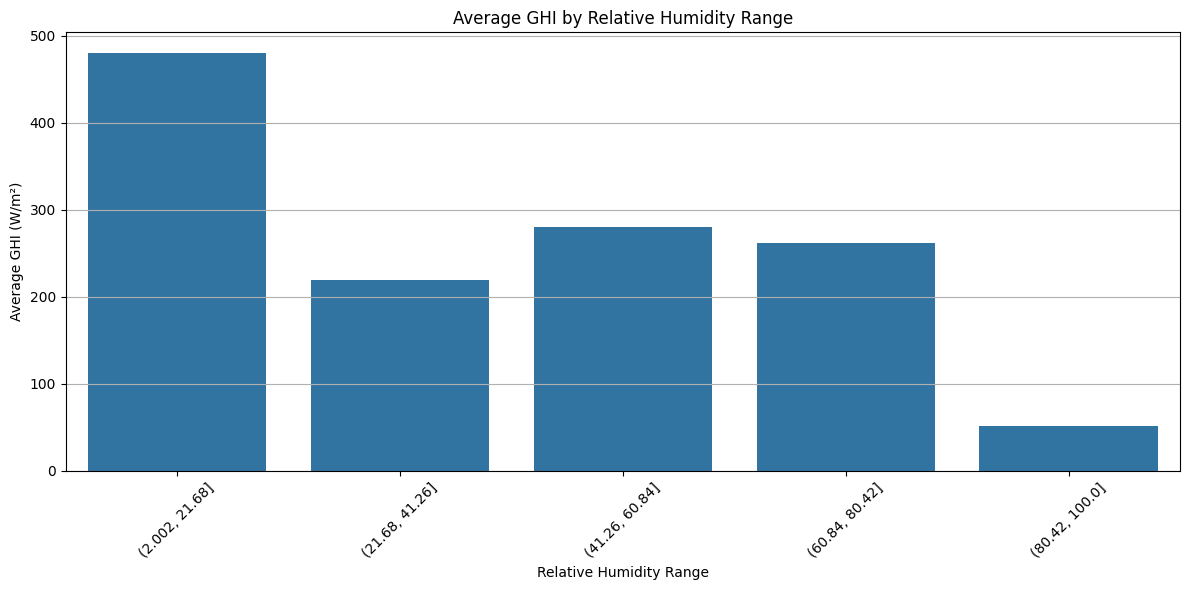

In [25]:
# 4. TEMPERATURE ANALYSIS
if all(col in df_clean.columns for col in ['RH', 'Tamb']):
    # Create RH bins
    df_clean['RH_bin'] = pd.cut(df_clean['RH'], bins=5)
    
    # Group by RH bins and calculate average temperature
    temp_by_rh = df_clean.groupby('RH_bin')['Tamb'].mean().reset_index()
    
    # Create bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='RH_bin', y='Tamb', data=temp_by_rh)
    plt.title('Average Temperature by Relative Humidity Range')
    plt.xlabel('Relative Humidity Range')
    plt.ylabel('Average Temperature (°C)')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig('../data/benin_temp_by_humidity.png')
    plt.show()
    
    # Check how RH affects GHI
    if 'GHI' in df_clean.columns:
        ghi_by_rh = df_clean.groupby('RH_bin')['GHI'].mean().reset_index()
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x='RH_bin', y='GHI', data=ghi_by_rh)
        plt.title('Average GHI by Relative Humidity Range')
        plt.xlabel('Relative Humidity Range')
        plt.ylabel('Average GHI (W/m²)')
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.savefig('../data/benin_ghi_by_humidity.png')
        plt.show()

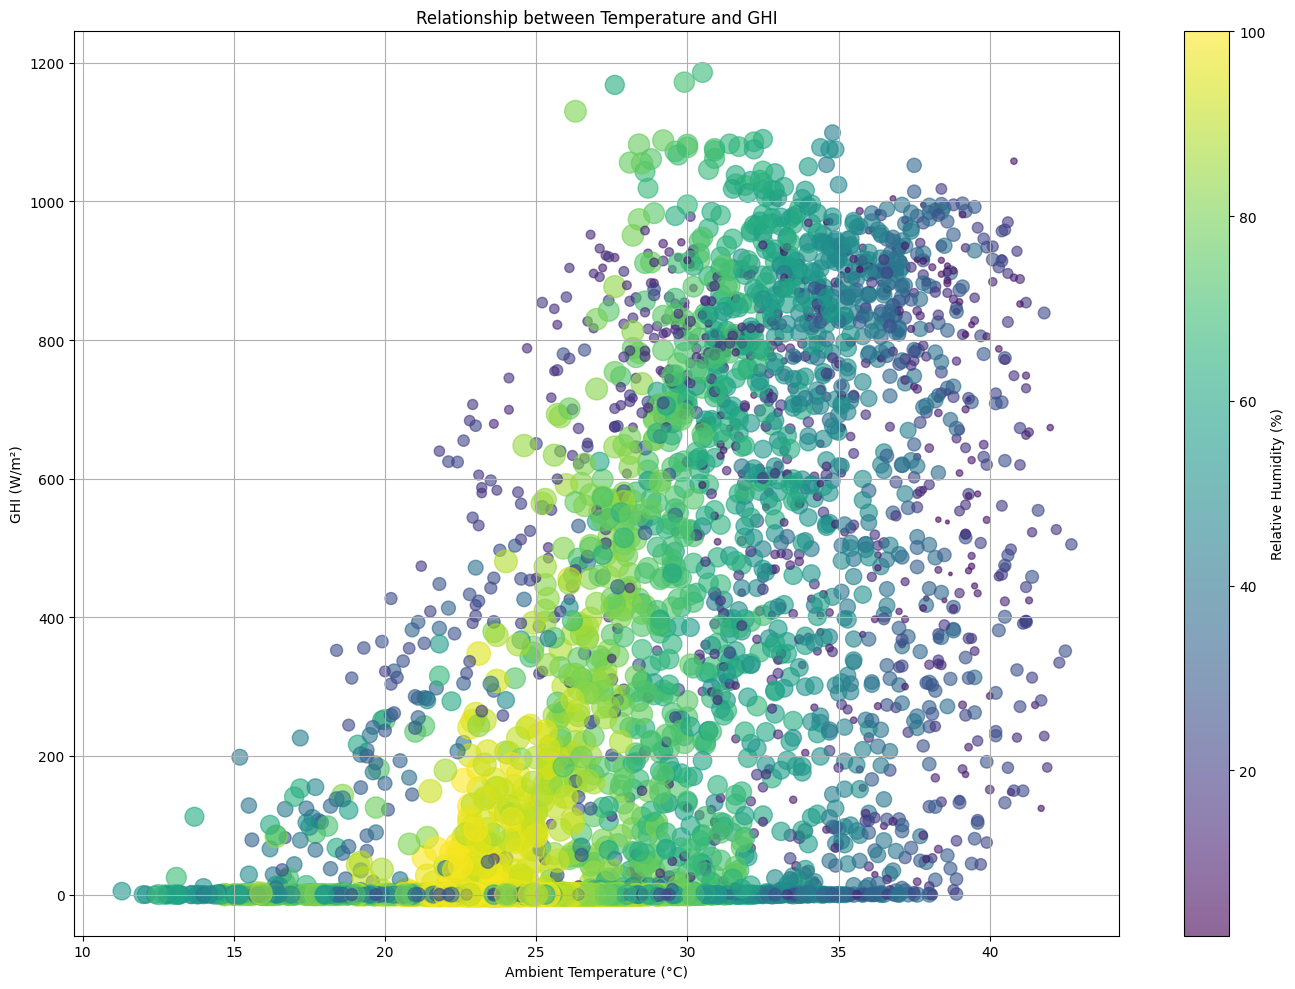

In [26]:
# 5. BUBBLE CHART
if all(col in df_clean.columns for col in ['GHI', 'Tamb']):
    plt.figure(figsize=(14, 10))
    
    # Choose bubble size variable
    if 'RH' in df_clean.columns:
        size_var = 'RH'
        size_label = 'Relative Humidity (%)'
    elif 'BP' in df_clean.columns:
        size_var = 'BP'
        size_label = 'Barometric Pressure (hPa)'
    else:
        size_var = None
    
    # Create sample for better visualization (too many points make the plot unclear)
    sample_size = min(5000, len(df_clean))
    df_sample = df_clean.sample(sample_size)
    
    if size_var:
        # Normalize sizes for better visualization
        sizes = df_sample[size_var] / df_sample[size_var].max() * 300
        
        # Create bubble chart with color gradient
        scatter = plt.scatter(df_sample['Tamb'], df_sample['GHI'], 
                             s=sizes, alpha=0.6, c=df_sample[size_var], 
                             cmap='viridis')
        
        # Add color bar
        cbar = plt.colorbar(scatter)
        cbar.set_label(size_label)
    else:
        # Use constant size if neither variable is available
        plt.scatter(df_sample['Tamb'], df_sample['GHI'], alpha=0.6)
    
    plt.title('Relationship between Temperature and GHI')
    plt.xlabel('Ambient Temperature (°C)')
    plt.ylabel('GHI (W/m²)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('../data/benin_bubble_chart.png')
    plt.show()